# RihkyeTask + LSTM_MD model

In [49]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append('..')
from temp_model import MD
from task import RihkyeTask

## Dataset

In [50]:
num_cueingcontext = 2
num_cue = 2
num_rule = 2
rule = [0, 1, 0, 1]
blocklen = [500, 500, 200]
block_cueingcontext = [0, 1, 0]
tsteps = 200
cuesteps = 100
batch_size = 1 # always set to 1 right now

dataset = RihkyeTask(num_cueingcontext=num_cueingcontext, num_cue=num_cue, num_rule=num_rule, rule=rule, blocklen=blocklen, \
block_cueingcontext=block_cueingcontext, tsteps=tsteps, cuesteps=cuesteps, batch_size=batch_size)

## Model

In [51]:
class LSTM_MD(nn.Module):
    """LSTM with a MD layer
    Parameters:
    input_size: int, LSTM input size
    hidden_size: int, LSTM hidden size
    output_size: int, output layer size
    num_layers: int, number of LSTM layers
    Num_MD: int, number of neurons in MD layer
    num_active: int, number of active neurons in MD layer (refer to top K winner-take-all)
    tsteps: int, length of a trial, equals to cuesteps + delaysteps
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers, Num_MD, num_active, tsteps):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.tsteps = tsteps
        
        dt = 0.001 # Hard-coded for now

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

        # MD layer
        self.md = MD(Nneur=hidden_size, Num_MD=Num_MD, num_active=num_active, dt=dt)
        #  initialize md_output
        self.md_output = np.zeros(Num_MD)
        index = np.random.permutation(Num_MD)
        self.md_output[index[:num_active]] = 1 # randomly set part of md_output to 1
        self.md_output_t = np.array([])

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, target):

        n_time = input.shape[0]
        batch_size = input.shape[1]

        LSTM_output = torch.zeros((n_time, batch_size, self.hidden_size))
        LSTM_hidden_t = torch.zeros((self.num_layers, batch_size, self.hidden_size))
        LSTM_cell_t = torch.zeros((self.num_layers, batch_size, self.hidden_size))

        for t in range(n_time):
            input_t = input[t, ...].unsqueeze(dim=0)
            target_t = target[t, ...].unsqueeze(dim=0)
            
            # Reinit MD activity for each trial
            if t % tsteps == 0: 
                self.md.init_activity()  # Reinit MD activity
 
            # TODO: integrate MD layer into LSTM_MD
            #self.md_output = self.md(LSTM_hidden_t)
            #self.md.MD2PFCMult = np.dot(self.md.wMD2PFCMult, self.md_output)
            #rec_inp = np.dot(self.pfc.Jrec, self.pfc.activity)
            #md2pfc_weights = (self.md.MD2PFCMult / np.round(self.md.Num_MD / 2))
            #md2pfc = md2pfc_weights * rec_inp  
            #md2pfc += np.dot(self.md.wMD2PFC / np.round(self.md.Num_MD /2), self.md_output)
            
            LSTM_output[t, :, :], (LSTM_hidden_t, LSTM_cell_t) = self.lstm(input_t, (LSTM_hidden_t, LSTM_cell_t))

        model_out = self.fc(LSTM_output)

        return model_out

## Training

In [52]:
import time

# Model settings
input_size = 4 # 4 cues
hidden_size = 200
output_size = 2 # 2 rules
num_layers = 1
Num_MD = 10
num_active = 5
tsteps = 200

model = LSTM_MD(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, Num_MD=Num_MD, \
    num_active=num_active, tsteps=tsteps)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


total_step = sum(blocklen)//batch_size
print_step = 10
running_loss = 0.0
running_train_time = 0
losses = []
timestamps = []
model_name = 'model-' + str(int(time.time()))
savemodel = False


for i in range(total_step):

    train_time_start = time.time()

    # extract data
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs, labels)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # normalization
    optimizer.step()

    # print statistics
    running_train_time += time.time() - train_time_start
    running_loss += loss.item()

    if i % print_step == (print_step - 1):
        print('Total step: {:d}'.format(total_step))
        print('Training sample index: {:d}-{:d}'.format(i+1-print_step, i+1))

        # running loss
        print('loss: {:0.5f}'.format(running_loss / print_step))
        losses.append(running_loss / print_step)
        timestamps.append(i+1-print_step)
        running_loss = 0.0

        # training time
        print('Predicted left training time: {:0.0f} s'.format(
        (running_train_time) * (total_step - i - 1) / print_step),
        end='\n\n')
        running_train_time = 0

        if savemodel:
            # save model every print_step
            fname = os.path.join('models', model_name + '.pt')
            torch.save(model.state_dict(), fname)

            # save info of the model
            fpath = os.path.join('models', model_name + '.txt')
            with open(fpath, 'w') as f:
                f.write('input_size = ' + str(input_size) + '\n')
                f.write('hidden_size = ' + str(hidden_size) + '\n')
                f.write('output_size = ' + str(output_size) + '\n')
                f.write('num_layers = ' + str(num_layers) + '\n')


print('Finished Training')

Total step: 1200
Training sample index: 0-10
loss: 0.34692
Predicted left training time: 258 s

Total step: 1200
Training sample index: 10-20
loss: 0.21996
Predicted left training time: 230 s

Total step: 1200
Training sample index: 20-30
loss: 0.12239
Predicted left training time: 223 s

Total step: 1200
Training sample index: 30-40
loss: 0.03862
Predicted left training time: 217 s

Total step: 1200
Training sample index: 40-50
loss: 0.04254
Predicted left training time: 256 s

Total step: 1200
Training sample index: 50-60
loss: 0.03076
Predicted left training time: 242 s

Total step: 1200
Training sample index: 60-70
loss: 0.02670
Predicted left training time: 267 s

Total step: 1200
Training sample index: 70-80
loss: 0.02212
Predicted left training time: 275 s

Total step: 1200
Training sample index: 80-90
loss: 0.01945
Predicted left training time: 263 s

Total step: 1200
Training sample index: 90-100
loss: 0.01909
Predicted left training time: 263 s

Total step: 1200
Training samp

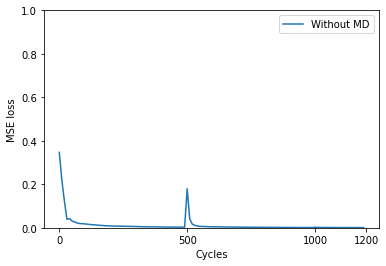

In [64]:
import matplotlib.pyplot as plt

plt.plot(timestamps, losses, label='Without MD')
plt.xlabel('Cycles')
plt.ylabel('MSE loss')
plt.legend()
plt.xticks([0, 500, 1000, 1200])
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

In [54]:
#lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1, proj_size=2)
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=1)
input = torch.randn(5, 3, 10)
#h0 = torch.randn(1, 3, 20)
#c0 = torch.randn(1, 3, 20)
output, _= lstm(input)

print(output.shape)

torch.Size([5, 3, 20])
